In [1]:
import pandas as pd
import numpy as np


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier


from sklearn.model_selection import cross_val_predict,cross_val_score,train_test_split


from sklearn.metrics import classification_report, confusion_matrix, roc_curve,auc, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score

import matplotlib.pyplot as plt

from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve

from sklearn.model_selection import GridSearchCV



In [2]:
creditcard = pd.read_csv('C:/Users/liuhu/Documents/Python/creditcard.csv')
creditcard['hour'] = creditcard['Time'].apply(lambda x: np.ceil(float(x)/3600) % 24)

In [3]:
creditcard.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,hour
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,1.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,1.0


In [4]:
# normalize/Standardize the "Amount", as its values are in very different scales to other Cols in the table. (tress based model may not need to do so)
creditcard['Amount'] = StandardScaler().fit_transform(creditcard[['Amount']])  # standardize the col and apply change

In [5]:
# Prep training / testing tables

target=creditcard['Class']
features=creditcard.drop(['Class'], axis=1)

x_train,x_test,y_train,y_test = train_test_split(features,target, stratify=target,test_size=0.35, random_state=1)

In [6]:
# Let's store our y_test legit and fraud counts for confusion matrix normalization purposes later on
y_test_legit = y_test.value_counts()[0]
y_test_fraud = y_test.value_counts()[1]

# Logistic regression

In [7]:
# Set up Logistic regression model with raw (unbalanced) and default balanced data strucutre

# Model with Unbalanced data
lr_model_unbalanced= LogisticRegression(solver='lbfgs', max_iter=1000) ## increased # of iteration for solver to converge

# Model with Balanced data
lr_model_balanced= LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000) ## increased # of iteration for solver to converge

## Fit the model regularly

In [8]:
log_fitted_unbalanced=lr_model_unbalanced.fit(x_train, y_train) # Unbalanced data

log_fitted_balanced=lr_model_balanced.fit(x_train, y_train) # Balanced data


In [9]:
log_predict_unbalanced=log_fitted_unbalanced.predict(x_test) # Unbalanced data

log_predict_balanced=log_fitted_balanced.predict(x_test) # Balanced data

### Evaluate Model Performance
    1. Confusion Matrix
    2. Normalized Confusion Matrix (unbalanced test data)
    3. Cross-validation Score + Testing Accuracy/f1 Score
    4. Classification Report
    5. Precison-Recall Curve
        5.1. F1-Score under different Precision
    6. ROC and AUC
    7. Calibration Curve/ Reliability Diagram
    
    8. Calibrated Model improvement

In [10]:
#1. Draw confusion matrix for analysis based on test data
#   Confusion matrix straitforwardedly tells how many are accurately classified and how many are not

confusion_unbalanced= confusion_matrix(y_test, log_predict_unbalanced) # Unbalanced data
print("Confusion matrix with Unbalanced training data:\n{}".format(confusion_unbalanced));

print("")

confusion_balanced= confusion_matrix(y_test, log_predict_balanced) # Balanced data
print("Confusion matrix with Balanced training data:\n{}".format(confusion_balanced))


Confusion matrix with Unbalanced training data:
[[99497    14]
 [   57   115]]

Confusion matrix with Balanced training data:
[[96161  3350]
 [   11   161]]


In [11]:
#2. Draw normalized confusion matrix based on unbalanced test data 
   # Build normalization matrix using the counts in test data for each category
    norm_matrix=np.array([[1/y_test_legit, 1/y_test_legit], [1/y_test_fraud, 1/y_test_fraud]])
    
    # normalize the unbalanced regular confusion matrix， each row sums up to 1
    confusion_norm_unbalanced = confusion_unbalanced*norm_matrix
    print("Normalized Confusion matrix with unbalanced training data:\n{}".format(confusion_norm_unbalanced ))
    
    print("")
    
    # normalize the Balanced regular confusion matrix， each row sums up to 1
    confusion_norm_balanced = confusion_balanced*norm_matrix
    print("Normalized Confusion matrix with balanced training data:\n{}".format(confusion_norm_balanced))    
    

Normalized Confusion matrix with unbalanced training data:
[[9.99859312e-01 1.40687964e-04]
 [3.31395349e-01 6.68604651e-01]]

Normalized Confusion matrix with balanced training data:
[[0.96633538 0.03366462]
 [0.06395349 0.93604651]]


In [12]:
# 3. Cross-validation score using training data and then using unseen test data for testing
log_CV_unbalanced=cross_val_score(lr_model_unbalanced, x_train, y_train, cv=5)
print("Cross Validation using unbalanced data：")
print(log_CV_unbalanced);
print("Averaged Cross Validation score:\n{}".format(np.mean(log_CV_unbalanced)));
print("Test Accuracy score:\n{}".format(lr_model_unbalanced.score(x_test, y_test)))
print("Test F1 score:\n{}".format(f1_score(y_test, log_predict_unbalanced)))

print("")


log_CV_balanced=cross_val_score(lr_model_balanced, x_train, y_train, cv=5)
print("Cross Validation using balanced data：")
print(log_CV_balanced);
print("Averaged Cross Validation score:\n{}".format(np.mean(log_CV_balanced)));
print("Test score:\n{}".format(lr_model_balanced.score(x_test, y_test)))
print("Test F1 score:\n{}".format(f1_score(y_test, log_predict_balanced)))


# Cross Validation gives an average evaluation of the model performance based on training data
#       However, even with a good cross-validated score, we want to see how the model performs 
#       with unseen data

# This score tells me overall model performance is good, but maynot be helpful if I only
#      focus on one side of the output like the classification report explicitly tells

Cross Validation using unbalanced data：
[0.99913572 0.99894666 0.99932478 0.99883862 0.99918971]
Averaged Cross Validation score:
0.9990870989316125
Test Accuracy score:
0.999287742142592
Test F1 score:
0.7641196013289036

Cross Validation using balanced data：
[0.96294396 0.97004727 0.96656313 0.96559082 0.96237576]
Averaged Cross Validation score:
0.9655041856894329
Test score:
0.9662831174824192
Test F1 score:
0.08742872658159109


In [13]:
# 4. Classificatoin report of the test data

print("Classification report with unbalanced data")
print(classification_report(y_test, log_predict_unbalanced))

print("")

print("Classification report with balanced data")
print(classification_report(y_test, log_predict_balanced))

# focuses on output 1 if that's the key interested event, f1-score=0.76 is pretty good. Do not get disturbed with output 0,
#      it's a large group, and large group in training set is easier to get higher score. 
#      also the averaged score for both outputs is not very helpful
# Learning: We are ok to only focus on the score for one output (given business needs)
#      rather than overall performance score 

# Using balanced data may not get better results, as shown below f1-score for output 1 based on balanced data is only 0.09


Classification report with unbalanced data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99511
           1       0.89      0.67      0.76       172

   micro avg       1.00      1.00      1.00     99683
   macro avg       0.95      0.83      0.88     99683
weighted avg       1.00      1.00      1.00     99683


Classification report with balanced data
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     99511
           1       0.05      0.94      0.09       172

   micro avg       0.97      0.97      0.97     99683
   macro avg       0.52      0.95      0.54     99683
weighted avg       1.00      0.97      0.98     99683



Average Precision Unbalanced:
0.7371193375952316
Average Precision Balanced:
0.7395771081610134


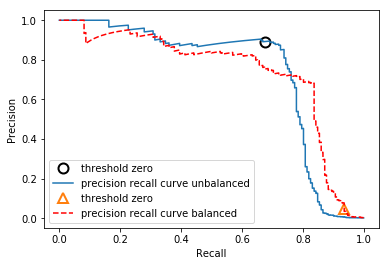

In [26]:
#5 Precision Recall Curve
precision_unbalanced, recall_unbalanced, thresholds_unbalanced=precision_recall_curve(y_test, lr_model_unbalanced.decision_function(x_test))
precision_balanced, recall_balanced, thresholds_balanced=precision_recall_curve(y_test, lr_model_balanced.decision_function(x_test))

precision_balanced, recall_balanced, thresholds_balanced=precision_recall_curve(y_test, lr_model_balanced.predict_proba(x_test)[:,1])
close_zero_balanced = np.argmin(np.abs(thresholds_balanced-0.999))
# If wanna see threhold in terms of probability (which is more understandable), we can use predict_proba()
# precision_balanced, recall_balanced, thresholds_balanced=precision_recall_curve(y_test, lr_model_balanced.predict_proba(x_test)[:,1])


# find threshold closest to zero
close_zero_unbalanced = np.argmin(np.abs(thresholds_unbalanced))
close_zero_balanced = np.argmin(np.abs(thresholds_balanced))

plt.plot( recall_unbalanced[close_zero_unbalanced],precision_unbalanced[close_zero_unbalanced], 'o', markersize=10, label="threshold zero", fillstyle="none", c='k', mew=2)
plt.plot(recall_unbalanced, precision_unbalanced, label="precision recall curve unbalanced")

plt.plot( recall_balanced[close_zero_balanced],precision_balanced[close_zero_balanced], '^', markersize=10, label="threshold zero", fillstyle="none", mew=2)
plt.plot(recall_balanced, precision_balanced, color='red', linestyle='dashed',  label="precision recall curve balanced")

plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend(loc="best")


Average_Precision_Unbalanced=average_precision_score(y_test, lr_model_unbalanced.decision_function(x_test))
Average_Precision_Balanced=average_precision_score(y_test, lr_model_balanced.decision_function(x_test))

print("Average Precision Unbalanced:\n{}".format(Average_Precision_Unbalanced));
print("Average Precision Balanced:\n{}".format(Average_Precision_Balanced))

# Balanced data fitted model performs better when Precision requirment is rougly lower than 0.7

# The red curve appears should have a threshold set at the point where (Pre=0.65, Rec=0.82 => f1=0.73),
# The blue curve appear should have a threshold set at the point where (Pre=0.82, Rec=0.75 => f1=0.76)
# We may want to select the blue model with the threshold=> f1=0.76,
#    however, if the business prefers higher Recall (cuz of cost) with a little lower Precision,
#    we may choose the red model instead 

# The default threshold (Decision function=0 or Probabily=0.5 are obviously not good threshold on the red curve)

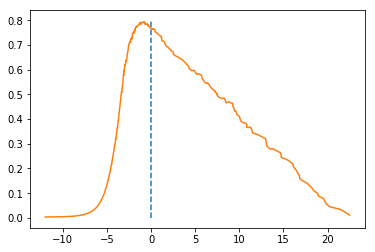

In [102]:
# 5.1 F1-Score under different Precision:

# As an example: we can have a side by side view of Precision, Recall and F1-Score for each Threshold
# SK-Learn made up a Precision=1, Recall=0 case to make the plot looks nice at the end point, in actual, this point doesn't
#   exist. As one is zero, the other is zero too. Calculation takes off this artifical point so we can have thresholds added
Information_Combine=[precision_unbalanced[:-1], recall_unbalanced[:-1], thresholds_unbalanced]
Information_Combine_DF=pd.DataFrame(Information_Combine)
Performance=Information_Combine_DF.T
Performance.columns=['Precision', 'Recall', 'Threshold']

Performance['F1-Score']=2*Performance['Precision']*Performance['Recall']/(Performance['Precision']+Performance['Recall'])
plt.plot([0, 0], [0, 0.8], linestyle='--')
plt.plot(Performance['Threshold'], Performance['F1-Score'])
# For the unbalanced data, the threashold bringing the highest F1-Score is lower than default 0

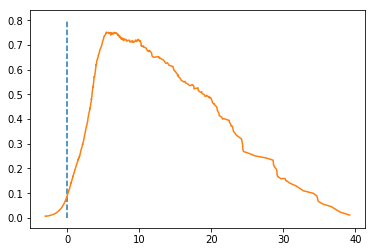

In [103]:
# For the balanced case
Information_Combine=[precision_balanced[:-1], recall_balanced[:-1], thresholds_balanced]
Information_Combine_DF=pd.DataFrame(Information_Combine)
Performance=Information_Combine_DF.T
Performance.columns=['Precision', 'Recall', 'Threshold']

Performance['F1-Score']=2*Performance['Precision']*Performance['Recall']/(Performance['Precision']+Performance['Recall'])
plt.plot([0, 0], [0, 0.8], linestyle='--')
plt.plot(Performance['Threshold'], Performance['F1-Score'])

AUC score w Unbalanced data:
0.9503941132603547
AUC score w Balanced data:
0.9844648470555901


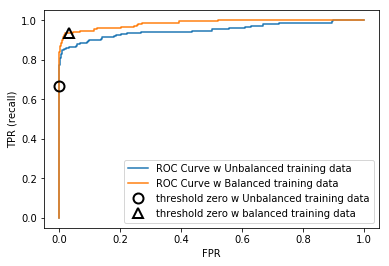

In [36]:
#6. AUC curve and Score

fpr_unCa_unBa, tpr_unCa_unBa, thresholds_unCa_unBa = roc_curve(y_test, log_fitted_unbalanced.decision_function(x_test))
plt.plot(fpr_unCa_unBa, tpr_unCa_unBa, label="ROC Curve w Unbalanced training data")
fpr_unCa_Ba, tpr_unCa_Ba, thresholds_unCa_Ba = roc_curve(y_test, log_fitted_balanced.decision_function(x_test))
plt.plot(fpr_unCa_Ba, tpr_unCa_Ba, label="ROC Curve w Balanced training data")

plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

# find threshold closest to zero
close_zero_unCa_unBa = np.argmin(np.abs(thresholds_unCa_unBa))
close_zero_unCa_Ba = np.argmin(np.abs(thresholds_unCa_Ba))

plt.plot(fpr_unCa_unBa[close_zero_unCa_unBa], tpr_unCa_unBa[close_zero_unCa_unBa], 'o', markersize=10,
label="threshold zero w Unbalanced training data", fillstyle="none", c='k', mew=2)
plt.plot(fpr_unCa_Ba[close_zero_unCa_Ba], tpr_unCa_Ba[close_zero_unCa_Ba], '^', markersize=10,
label="threshold zero w balanced training data", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)


auc_unCa_unBa=roc_auc_score(y_test,  log_fitted_unbalanced.decision_function(x_test))
auc_unCa_Ba=roc_auc_score(y_test,  log_fitted_balanced.decision_function(x_test))

print("AUC score w Unbalanced data:\n{}".format(auc_unCa_unBa))
print("AUC score w Balanced data:\n{}".format(auc_unCa_Ba))

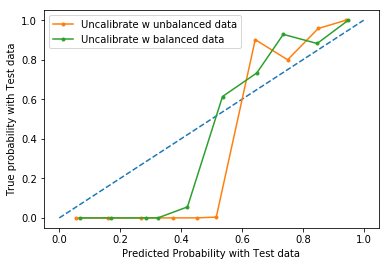

In [37]:
#7. Calibration Curve/ Reliability Diagram

# Test set predicted probabily
probs_unCa_unBa=log_fitted_unbalanced.decision_function(x_test) # Probility Estimate
prob_true_unCa_unBa, prob_pred_unCa_unBa=calibration_curve(y_test, probs_unCa_unBa, n_bins=10, normalize=True)

probs_unCa_Ba=log_fitted_balanced.decision_function(x_test) # fit log model
prob_true_unCa_Ba, prob_pred_unCa_Ba=calibration_curve(y_test, probs_unCa_Ba, n_bins=10, normalize=True)


# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
plt.plot(prob_pred_unCa_unBa, prob_true_unCa_unBa, marker='.', label="Uncalibrate w unbalanced data")
plt.plot(prob_pred_unCa_Ba, prob_true_unCa_Ba, marker='.', label="Uncalibrate w balanced data")

plt.xlabel("Predicted Probability with Test data")
plt.ylabel("True probability with Test data")
plt.legend(loc="best")

# the plot shows 

## #8.Fit and improve the model with Calibrated prediction

In [38]:
# Calibration classifier/model, built in additional to other models.
# With this class, the base_estimator is fit on the train set of the cross-validation generator and 
#      the test set is used for calibration. The probabilities for each of the folds are then averaged for prediction.

calibrated_unbalanced=CalibratedClassifierCV(lr_model_unbalanced, method='isotonic', cv=5) 
calibrated_unbalanced.fit(x_train, y_train) # fit calibration model

calibrated_balanced=CalibratedClassifierCV(lr_model_balanced, method='isotonic', cv=5) 
calibrated_balanced.fit(x_train, y_train)

CalibratedClassifierCV(base_estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False),
            cv=5, method='isotonic')

method : ‘sigmoid’ or ‘isotonic’
The method to use for calibration. Can be ‘sigmoid’ which corresponds to Platt’s method or ‘isotonic’ which is a non-parametric approach. It is not advised to use isotonic calibration with too few calibration samples (<<1000) since it tends to overfit. Use sigmoids (Platt’s calibration) in this case.

In [39]:
probs_Ca_unBa = calibrated_unbalanced.predict_proba(x_test)[:, 1]

probs_Ca_Ba = calibrated_balanced.predict_proba(x_test)[:, 1]


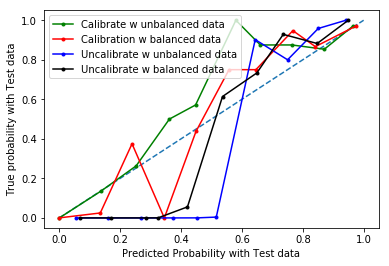

In [40]:
prob_true_Ca_unBa, prob_pred_Ca_unBa=calibration_curve(y_test, probs_Ca_unBa, n_bins=10, normalize=True)
prob_true_Ca_Ba, prob_pred_Ca_Ba=calibration_curve(y_test, probs_Ca_Ba, n_bins=10, normalize=True)

# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')  # graph 1
# plot calibrated reliability
plt.plot(prob_pred_Ca_unBa, prob_true_Ca_unBa, marker='.', color='green', label="Calibrate w unbalanced data") # graph 2
plt.plot(prob_pred_Ca_Ba, prob_true_Ca_Ba, marker='.', color='red', label="Calibration w balanced data") # graph 3

plt.plot(prob_pred_unCa_unBa, prob_true_unCa_unBa, marker='.', color='blue', label="Uncalibrate w unbalanced data")
plt.plot(prob_pred_unCa_Ba, prob_true_unCa_Ba, marker='.', color='black', label="Uncalibrate w balanced data")

plt.xlabel("Predicted Probability with Test data")
plt.ylabel("True probability with Test data")
plt.legend(loc="best")

In [41]:
# Classification report of test data based on (un)calibrated mdoel+(un)balanced training data 
print("Classification report with uncalibrated model and unbalanced data")
print(classification_report(y_test, log_predict_unbalanced))

print("Classification report with uncalibrated model and balanced data")
print(classification_report(y_test, log_predict_balanced))

print("")

print("Classification report with calibrated model and unbalanced data")
calibrated_predict_unbalanced=calibrated_unbalanced.fit(x_train, y_train).predict(x_test)
print(classification_report(y_test, calibrated_predict_unbalanced))

print("Classification report with calibrated model and balanced data")
calibrated_predict_balanced=calibrated_balanced.fit(x_train, y_train).predict(x_test)
print(classification_report(y_test, calibrated_predict_balanced))

Classification report with uncalibrated model and unbalanced data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99511
           1       0.89      0.67      0.76       172

   micro avg       1.00      1.00      1.00     99683
   macro avg       0.95      0.83      0.88     99683
weighted avg       1.00      1.00      1.00     99683

Classification report with uncalibrated model and balanced data
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     99511
           1       0.05      0.94      0.09       172

   micro avg       0.97      0.97      0.97     99683
   macro avg       0.52      0.95      0.54     99683
weighted avg       1.00      0.97      0.98     99683


Classification report with calibrated model and unbalanced data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99511
           1       0.89      0.66      0.7

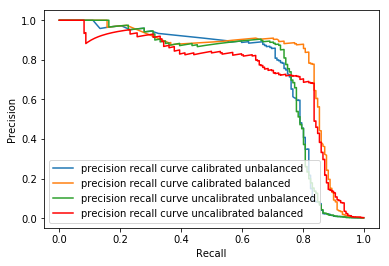

In [49]:
# Precision Recall Curve
precision_Ca_unBa, recall_Ca_unBa, thresholds_Ca_unBa=precision_recall_curve(y_test, calibrated_unbalanced.predict_proba(x_test)[:,1])
precision_Ca_Ba, recall_Ca_Ba, thresholds_Ca_unBa=precision_recall_curve(y_test, calibrated_balanced.predict_proba(x_test)[:, 1])

plt.plot( recall_Ca_unBa, precision_Ca_unBa, label="precision recall curve calibrated unbalanced")
plt.plot(recall_Ca_Ba, precision_Ca_Ba,    label="precision recall curve calibrated balanced")

plt.plot(recall_unbalanced,precision_unbalanced,  label="precision recall curve uncalibrated unbalanced")
plt.plot(recall_balanced, precision_balanced, color='red',  label="precision recall curve uncalibrated balanced")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc=3)


AUC score w Uncalibrated Unbalanced data:
0.9503941132603547
AUC score w Uncalibrated Balanced data:
0.9844648470555901
AUC score w Calibrated Unbalanced data:
0.9544958276203193
AUC score w Calibrated Balanced data:
0.975758143367579


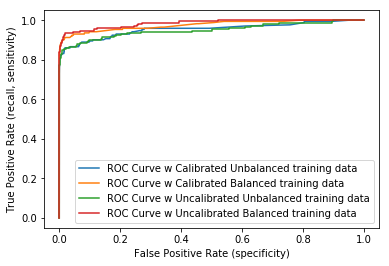

In [104]:
# ROC Curve

fpr_Ca_unBa, tpr_Ca_unBa, thresholds_Ca_unBa = roc_curve(y_test, calibrated_unbalanced.predict_proba(x_test)[:, 1])
plt.plot(fpr_Ca_unBa, tpr_Ca_unBa, label="ROC Curve w Calibrated Unbalanced training data")
fpr_Ca_Ba, tpr_Ca_Ba, thresholds_Ca_Ba = roc_curve(y_test, calibrated_balanced.predict_proba(x_test)[:, 1])
plt.plot(fpr_Ca_Ba, tpr_Ca_Ba, label="ROC Curve w Calibrated Balanced training data")

plt.plot(fpr_unCa_unBa, tpr_unCa_unBa, label="ROC Curve w Uncalibrated Unbalanced training data")
plt.plot(fpr_unCa_Ba, tpr_unCa_Ba, label="ROC Curve w Uncalibrated Balanced training data")

plt.xlabel("False Positive Rate (specificity)")
plt.ylabel("True Positive Rate (recall, sensitivity)")

plt.legend()


auc_Ca_unBa=roc_auc_score(y_test,  calibrated_unbalanced.predict_proba(x_test)[:, 1])
auc_Ca_Ba=roc_auc_score(y_test,  calibrated_balanced.predict_proba(x_test)[:, 1])

print("AUC score w Uncalibrated Unbalanced data:\n{}".format(auc_unCa_unBa))
print("AUC score w Uncalibrated Balanced data:\n{}".format(auc_unCa_Ba))
print("AUC score w Calibrated Unbalanced data:\n{}".format(auc_Ca_unBa))
print("AUC score w Calibrated Balanced data:\n{}".format(auc_Ca_Ba))

Conclusion: 

1. Calibration plot shows Isotonic Calibrated model with Balanced training data out performed
2. ROC and AUC score slightly favors Uncalibrated model with Balanced training data over the Calibrated one
3. Classification report shows outformed f1-score for the Calibrated model with Balanced training data
4. (We also tried the Sigmoid Calibrated model, but performance is slow)

Therefore, we choose the Isotonic Calibrated Logistic regression with balanced training data for next step comparison
